# Credit Default Prediction: Baseline Modelling

This notebook continues from `01_EDA_dataprep.ipynb`, using the preprocessed
loan default dataset (`Preprocessed_Data.csv`). Goals:

- Train a few baseline classifiers for Probability of Default (PD).
- Understand the classification metrics (Accuracy, Precision, Recall, F1-score, ROC–AUC)

In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Plot style
plt.style.use("default")
sns.set_theme()


In [2]:
data_path = "Preprocessed_Data.csv"

loan_data = pd.read_csv(data_path)

print("Shape of dataset:", loan_data.shape)
print("\nColumns:\n", loan_data.columns.tolist())

Shape of dataset: (148670, 28)

Columns:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Upfront_charges', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']


### 1. Train–Test Split

We now:

- Define **features** `X` (all columns except the target `Status`).
- Define **target** `y` (`Status`).
- Split into **train** and **test** sets (80% / 20%).


In [3]:


#setting target attribute 'Status'
X=loan_data.drop('Status',axis='columns')
Y=loan_data.Status


In [4]:
# Define target and features
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((118936, 27), (29734, 27), (118936,), (29734,))

In [5]:
print("Class balance in full dataset:")
print(loan_data["Status"].value_counts(), "\n")

print("Class balance in y_train:")
print(y_train.value_counts(), "\n")

print("Class balance in y_test:")
print(y_test.value_counts())


Class balance in full dataset:
Status
0    112031
1     36639
Name: count, dtype: int64 

Class balance in y_train:
Status
0    89537
1    29399
Name: count, dtype: int64 

Class balance in y_test:
Status
0    22494
1     7240
Name: count, dtype: int64


### 2. Baseline Classification Models

We train several standard classifiers:

- Logistic Regression  
- K-Nearest Neighbours (KNN)  
- Decision Tree  
- Random Forest  
- Support Vector Machine (SVM)

The aim is to compare metrics of the baseline models.

In [6]:
# Function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fit a classifier and compute standard metrics on the test set.

    Returns a dict with:
    - Accuracy
    - Precision
    - Recall
    - F1-Score
    - ROC AUC  (if probabilities are available)
    """
    # Train
    model.fit(X_train, y_train)

    # Class predictions
    y_pred = model.predict(X_test)

    # Probability predictions for ROC–AUC (if available)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
    }

    if y_pred_proba is not None:
        metrics["ROC AUC"] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics["ROC AUC"] = np.nan

    return metrics, y_pred, y_pred_proba

def evaluate_model_old(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Get the probability predictions for ROC AUC (only for applicable models)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = np.zeros(len(y_test))
    
    # Evaluate the model using several metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if np.any(y_pred_proba) else None
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

results = {}
stored_preds = {}  # to reuse for plots later

for name, clf in models.items():
    print(f"Training {name}...")
    metrics, y_pred, y_proba = evaluate_model(
        clf, X_train, y_train, X_test, y_test
    )
    results[name] = metrics
    stored_preds[name] = {"y_pred": y_pred, "y_proba": y_proba}

results_df = pd.DataFrame(results).T.sort_values("ROC AUC", ascending=False)
results_df.round(4)


Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training K-Nearest Neighbors...
Training Decision Tree...
Training Random Forest...


,Accuracy,Precision,Recall,F1-Score,ROC AUC
Random Forest,0.9999,1.0000,0.9994,0.9997,1.0000
Decision Tree,0.9995,0.9988,0.9992,0.9990,0.9994
K-Nearest Neighbors,0.9250,0.7879,0.9468,0.8601,0.9640
Logistic Regression,0.7614,0.5767,0.0753,0.1332,0.6932


The table above shows baseline performance for each model. 

### Interpreting the metrics

- Accuracy:  Fraction of all loans classified correctly. Can be misleading when the
  dataset is imbalanced (many more non-defaults than defaults).

- Precision:  Of all loans the model predicts as default, what proportion actually
  defaulted? High precision means few false alarms.

- Recall:  Of all loans that actually defaulted, what proportion did we correctly predict?
  In credit risk this is crucial, because missed defaults (false negatives) are
  costly.

- F1 score: Harmonic mean of precision and recall. Useful as a single number when we want
  a balance between catching defaults and avoiding too many false alarms.

- ROC–AUC: Measures overall discriminatory power: the probability that the model assigns
  a higher risk score to a randomly chosen defaulted loan than to a randomly
  chosen non-default.  
  - 0.5 ≈ random guessing  
  - 1.0 = perfect ranking


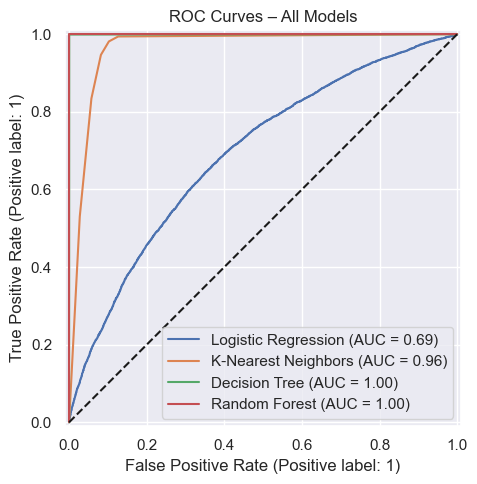

In [8]:
plt.figure(figsize=(7, 5))

for name, clf in models.items():
    y_proba = stored_preds[name]["y_proba"]
    if y_proba is None:
        continue  # skip models without predict_proba

    RocCurveDisplay.from_predictions(
        y_test, y_proba, name=name, ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")

plt.title("ROC Curves – All Models")
plt.grid(True)
plt.tight_layout()
plt.show()


In a credit risk setting we usually:

- Use ROC–AUC to compare overall ranking ability of models.  
- Look at Recall to see how many defaults we capture at the chosen threshold (especially important when missing a default is very expensive).  
- Use Precision to understand the trade-off between catching more defaults and producing too many false positives.

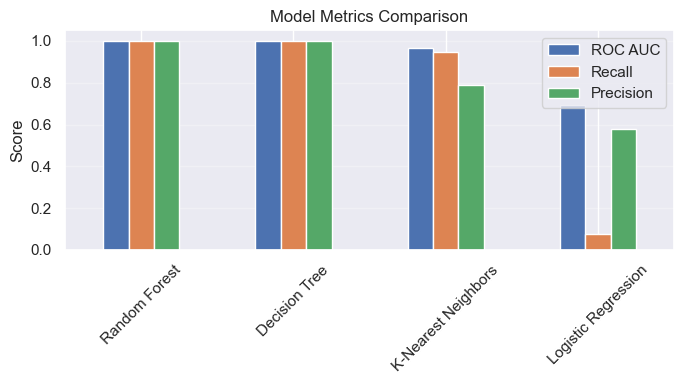

In [9]:
metrics = results_df[["ROC AUC", "Recall","Precision"]]

metrics.plot(kind="bar", figsize=(7, 4), rot=45)
#plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Metrics Comparison")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
